In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import launch_sim
%load_ext autoreload
%autoreload 2
import time
from random import shuffle

In [2]:
import inspect
import math

In [3]:
class saddle_space:
    def __init__(self):
        self.dim = 2
    
    def fitness(self,psi):
        res = launch_sim(psi)
        return res
    
    def get_bounds(self):
        return ([0,0],[99,99])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
        x,y = zip(*w)
        plt.scatter(x,y,4,'k',edgecolors='face')
        plt.scatter(w[idx][0],w[idx][1],15,'y',edgecolors='k')

In [4]:
class salimans_nes:
    def __init__(self,iter=12):
        super(salimans_nes,self).__init__()
        self.prevx,self.prevy = [],[]
        
        self.iter=iter # number of steps towards estimated gradient
    
    def evolve(self,pop):
        if len(pop) == 0:
            return pop
        sigma = 3
        alpha = 0.03 # learningrate
        
        # plotting
        plotting = False
        if plotting:
            plt.figure(figsize=(self.iter,self.iter))
            no_rows = int(self.iter/4+1)
            gs = gridspec.GridSpec(no_rows,4)
            plot_index = 0
        
        #for each iteration, jitter around starting points, and move in the
        #best direction (weighted average jitter coordinates according to 
        #fitness score)
        for i in range(self.iter):
            
            if plotting:
                ax1=plt.subplot(gs[int(i/4),plot_index])
                plot_index += 1
                if plot_index == 4:
                    plot_index = 0
                plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
            
            #get the population    
            wl = pop.get_x()
            
            #do the jittering and selection
            j=0
            for w in wl:
                noise = np.random.randn(200,2)
                wp = [[min(99,max(0,x)),min(99,max(0,y))] for [x,y] in np.expand_dims(w, 0) + sigma*noise]
                
                
                
                if plotting:
                    x,y = zip(*wp)
                    plt.scatter(x,y,4,'k',edgecolors='face')
                R = np.array([prob.fitness(wi)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
                u = alpha * g
                w += u # mutate the population
                w = [min(99,max(0,w[0])),min(99,max(0,w[1]))] # bounds
                pop.set_x(j,w)# make the move previously selected
                j+=1
        return pop

    def get_name(self):
        return f"Oisin's big-dick omegafantastic algorithm"

In [5]:
def pygmo_es():
    uda = salimans_nes(iter=25)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow

    archi = pg.archipelago(algo=uda, prob=udp, n=50, pop_size=30)
    archi.evolve()
    sols = archi.get_champions_f()
    idx = sols.index(min(sols))
    #print("Done!! Solutions found are: ")
    #print(archi.get_champions_f())
    udp.plot(archi.get_champions_x(),idx)

    #pop = pg.population(prob,10,3)
    #algo.evolve(pop)

In [6]:
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import *
derp = launch_sim([-2.09, -0.0001, 3.01])

deny step 0.012179530089969815,0.00020700896068361456
deny step 0.008422064443540723,0.00011975085561621603


In [7]:
if __name__ == '__main__':
    pass
    #pygmo_es()

ValueError: not enough values to unpack (expected 3, got 2)

In [11]:
from mpl_toolkits.mplot3d import Axes3D


In [19]:
xa=[d[0] for d in derp[1]]
ya=[d[1] for d in derp[1]]
ha = [d[4] for d in derp[1]]

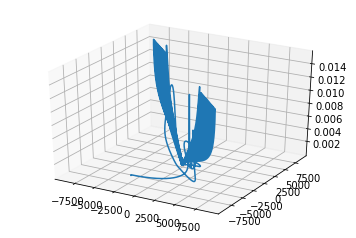

In [24]:
fig = plt.figure()
ax = fig.gca(projection="3d")

ax.plot(xa, ya, ha)